<hr>

# ST1511 AI and Machine Learning CA1 Assignment (Regression)
<hr>

Name: Lee Hong Yi <br>
Class: DAAA/FT/2A/05 <br>
Admin Number: p2223010 <br>

__Objective:__ <br>
Predict the price of a house in the United States based on various factors.

__Background Information:__<br>
The price of a house is based on several factors, such as it's location, area, and amenities, such as bedrooms, toilets, and renovation status.


__Additional Information:__ <br>

<hr>
<font size = 5>Importing Libraries</font>
<hr>

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, r2_score
from sklearn.model_selection import ShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

<font size = 5> Preparing data.</font> <br>

Since the data has already been collected, we can move straight onto preparing the data for training by the model.

In [67]:
original_data = pd.read_csv("./housing_dataset.csv")
eda_data = original_data.copy()

In [68]:
eda_data.describe()

,House ID,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($)
count,545.00000,545.000000,545.000000,545.000000,545.000000,5.450000e+02
mean,272.00000,515.054128,2.965138,1.286239,1.805505,4.766729e+05
std,157.47222,217.014102,0.738064,0.502470,0.867492,1.870440e+05
min,0.00000,165.000000,1.000000,1.000000,1.000000,1.750000e+05
25%,136.00000,360.000000,2.000000,1.000000,1.000000,3.430000e+05
50%,272.00000,460.000000,3.000000,1.000000,2.000000,4.340000e+05
75%,408.00000,636.000000,3.000000,2.000000,2.000000,5.740000e+05
max,544.00000,1620.000000,6.000000,4.000000,4.000000,1.330000e+06


In [69]:
display(eda_data.value_counts("City"))
display(eda_data.value_counts("No. of Bedrooms"))
display(eda_data.value_counts("No. of Toilets"))
display(eda_data.value_counts("Stories"))

City
New York    158
Seattle     134
Boston      105
Denver       89
Chicago      59
dtype: int64

No. of Bedrooms
3    300
2    136
4     95
5     10
1      2
6      2
dtype: int64

No. of Toilets
1    401
2    133
3     10
4      1
dtype: int64

Stories
2    238
1    227
4     41
3     39
dtype: int64

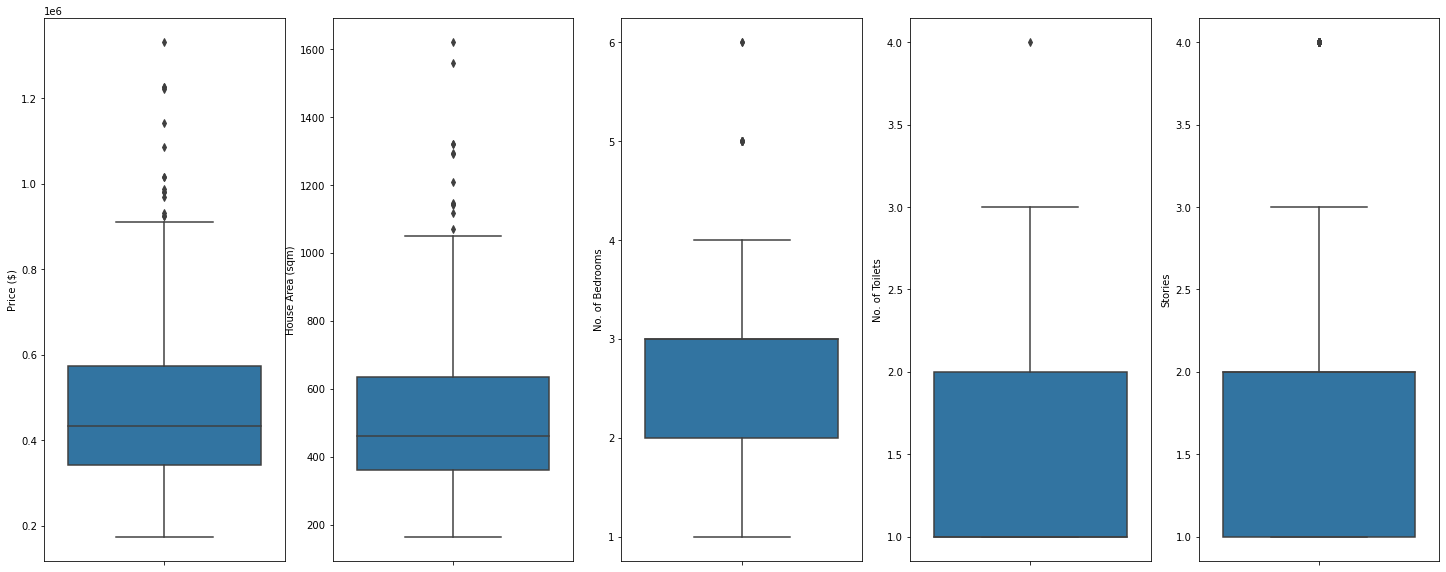

In [70]:
fig, ax = plt.subplots(1,5, figsize = (25,10))

sns.boxplot(data = eda_data, ax = ax[0], y = "Price ($)")
sns.boxplot(data = eda_data, ax = ax[1], y = "House Area (sqm)")
sns.boxplot(data = eda_data, ax = ax[2], y = "No. of Bedrooms")
sns.boxplot(data = eda_data, ax = ax[3], y = "No. of Toilets")
sns.boxplot(data = eda_data, ax = ax[4], y = "Stories")

plt.show()

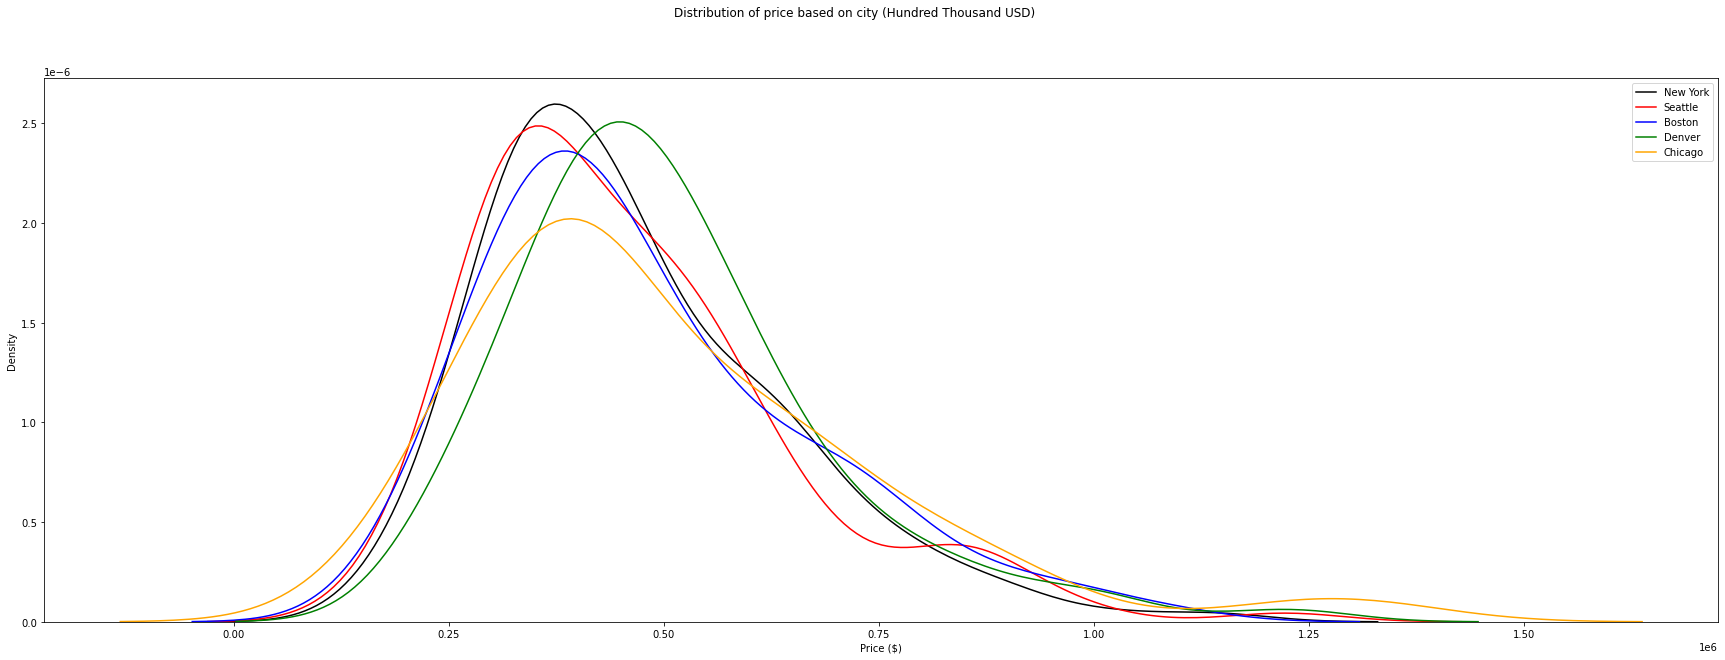

In [71]:
fig, ax = plt.subplots(figsize = (30,10))
fig = sns.kdeplot(data = eda_data[eda_data["City"] == "New York"]["Price ($)"], color = "black", label = "New York")
fig2 = sns.kdeplot(data = eda_data[eda_data["City"] == "Seattle"]["Price ($)"], color = "red", label = "Seattle")
fig3 = sns.kdeplot(data = eda_data[eda_data["City"] == "Boston"]["Price ($)"], color = "blue", label = "Boston")
fig4 = sns.kdeplot(data = eda_data[eda_data["City"] == "Denver"]["Price ($)"], color = "green", label = "Denver")
fig5 = sns.kdeplot(data = eda_data[eda_data["City"] == "Chicago"]["Price ($)"], color = "orange", label = "Chicago")
plt.suptitle("Distribution of price based on city (Hundred Thousand USD)")
ax.legend()
plt.show()


From the above graph, we can see that the city of Denver has houses that are higher on average, as it's price distribution curve is skewed further to the right as compared to the other cities.

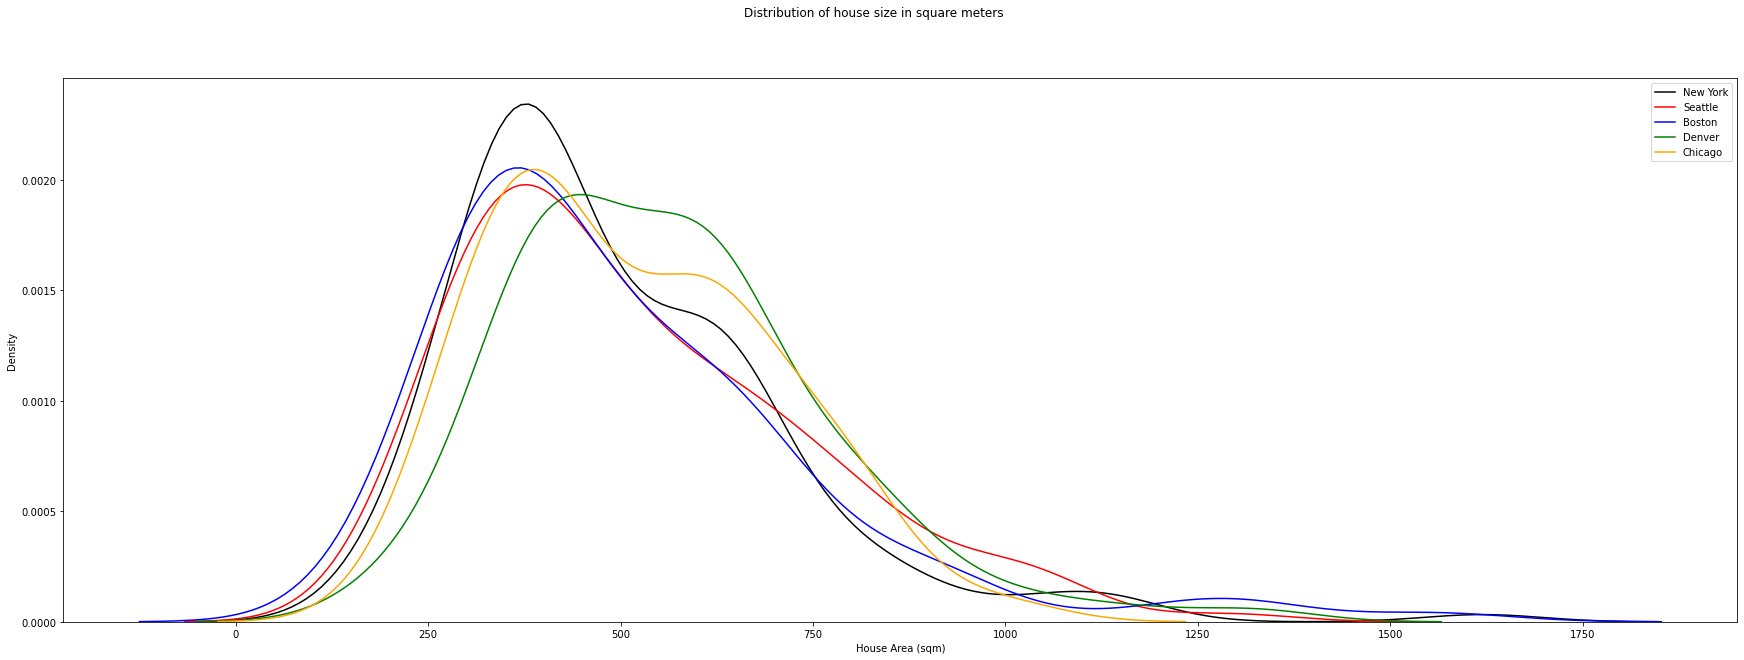

In [72]:
fig, ax = plt.subplots(figsize = (30,10))
fig = sns.kdeplot(data = eda_data[eda_data["City"] == "New York"]["House Area (sqm)"], color = "black", label = "New York")
fig2 = sns.kdeplot(data = eda_data[eda_data["City"] == "Seattle"]["House Area (sqm)"], color = "red", label = "Seattle")
fig3 = sns.kdeplot(data = eda_data[eda_data["City"] == "Boston"]["House Area (sqm)"], color = "blue", label = "Boston")
fig4 = sns.kdeplot(data = eda_data[eda_data["City"] == "Denver"]["House Area (sqm)"], color = "green", label = "Denver")
fig5 = sns.kdeplot(data = eda_data[eda_data["City"] == "Chicago"]["House Area (sqm)"], color = "orange", label = "Chicago")
plt.suptitle("Distribution of house size in square meters")
ax.legend()
plt.show()

From the above graph, we can also see that the city of Denver has houses that are larger on average, as it's distribution curve is skewed further to the right, while also having a lower proportion below ~400sqm as compared to other cities. In addition, the city of New York has more houses that are around 300 sqm, given that the graph has a higher peak at that point on the scale. 

Creating a correlogram to highlight the most correlated variables in the data table.

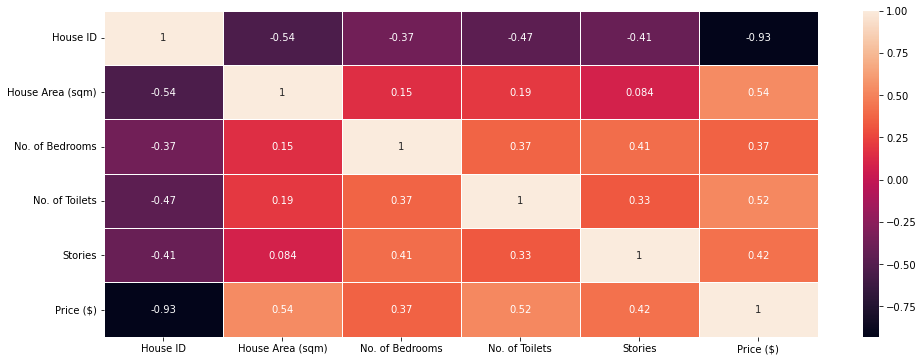

In [73]:
plt.figure(figsize = (16,6))
sns.heatmap(eda_data.corr(), annot = True, linewidths= 0.5)
plt.show()

<font size = 5>Feature Engineering</font>

Using the "House Area (sqm)" column, as well as the "Price ($)" column to calculate a new feature, called "Price / PSM".

In [74]:
price_Arr = []
for row in original_data.itertuples():
    price_Arr.append(row[8] / row[3])
original_data["price_psm"] = price_Arr

<font size = 5>Preparing the data for training.</font>

In [75]:
target_data = pd.DataFrame(original_data["Price ($)"])
analysis_data = original_data.drop(columns = ["House ID",'Price ($)'])

display(analysis_data.head())
display(target_data.head())

analysis_data = pd.get_dummies(analysis_data)
display(analysis_data.head())
X_train, X_test, y_train, y_test = train_test_split(analysis_data, target_data, test_size=0.3, random_state=42)

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,price_psm
0,Chicago,742.0,4,2,3,furnished,1792.452830
1,Denver,896.0,4,4,4,furnished,1367.187500
2,Chicago,996.0,3,2,2,semi-furnished,1229.919679
3,Seattle,750.0,4,2,2,furnished,1628.666667
4,New York,742.0,4,1,2,furnished,1537.735849


,Price ($)
0,1330000
1,1225000
2,1225000
3,1221500
4,1141000


,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,price_psm,City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,742.0,4,2,3,1792.452830,0,1,0,0,0,1,0,0
1,896.0,4,4,4,1367.187500,0,0,1,0,0,1,0,0
2,996.0,3,2,2,1229.919679,0,1,0,0,0,0,1,0
3,750.0,4,2,2,1628.666667,0,0,0,0,1,1,0,0
4,742.0,4,1,2,1537.735849,0,0,0,1,0,1,0,0


<font size = 5>Choosing / training a model</font>

Setting up scoring metrics for use later.

In [76]:
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


scoring_functions = {
    "mape":make_scorer(mean_absolute_percentage_error),
    "r2":make_scorer(r2_score)
}

Attempting to train and tune a RandomForestRegressor model, using GridSearchCV to identify the best parameters.

In [77]:
param_grid = dict(n_estimators=list(range(1,50)))
rfr = RandomForestRegressor(n_jobs = -1)
grid = GridSearchCV(rfr, param_grid, scoring = scoring_functions, verbose=1, refit = False)
rfr_search = grid.fit(X_train, np.ravel(y_train))
results = grid.cv_results_

#generating graphs to show impact of variables on scoring metrics.
fig = make_subplots(rows=2, cols=1, subplot_titles=("Viewing Mean Absolute Percentage Error based on n_estimators (Lower is better.)","Viewing r2 score based on n_estimators (Higher is better.)"), shared_xaxes= True, vertical_spacing= 0.1)
fig.add_trace(go.Scatter(x = results["param_n_estimators"], y = results["mean_test_mape"]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = results["param_n_estimators"], y = results["mean_test_r2"]), row = 2, col = 1)
fig.update_layout(height=600, width=1500)
fig.show()

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [91]:
param_grid = dict(C = np.arange(0.1,100,0.1))
svr_model = SVR()
grid = GridSearchCV(svr_model, param_grid, scoring = scoring_functions, verbose=1, refit = False)
svr_search = grid.fit(X_train, np.ravel(y_train))
results = grid.cv_results_
display(results)

#generating graphs to show impact of variables on scoring metrics.
fig = make_subplots(rows=2, cols=1, subplot_titles=("Viewing Mean Absolute Percentage Error based on n_estimators (Lower is better.)","Viewing r2 score based on n_estimators (Higher is better.)"), shared_xaxes= True, vertical_spacing= 0.1)
fig.add_trace(go.Scatter(x = results["param_C"], y = results["mean_test_mape"]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = results["param_C"], y = results["mean_test_r2"]), row = 2, col = 1)
fig.update_layout(height=600, width=1500)
fig.show()

Fitting 5 folds for each of 999 candidates, totalling 4995 fits


{'mean_fit_time': array([0.00497336, 0.00457988, 0.00452309, 0.00423698, 0.00464845,
        0.00493374, 0.00511861, 0.00464716, 0.00476985, 0.0049314 ,
        0.00494146, 0.0047482 , 0.00482025, 0.00437837, 0.00508456,
        0.004673  , 0.00490408, 0.00481882, 0.00461326, 0.00533133,
        0.00489883, 0.00444498, 0.00477533, 0.00469112, 0.00463433,
        0.0049191 , 0.00491724, 0.00493274, 0.00480227, 0.00493884,
        0.00512266, 0.00468135, 0.00505676, 0.00492749, 0.00518498,
        0.00526853, 0.00553718, 0.00547266, 0.0050209 , 0.00468621,
        0.00482311, 0.00481143, 0.00455337, 0.0048048 , 0.0048636 ,
        0.00471401, 0.00468345, 0.00459838, 0.00499282, 0.0049149 ,
        0.0052309 , 0.00464478, 0.00432525, 0.004633  , 0.00488505,
        0.0046823 , 0.0049994 , 0.004424  , 0.00485115, 0.00444899,
        0.00471444, 0.00471196, 0.00480309, 0.00481334, 0.00462408,
        0.00477095, 0.00480962, 0.00475063, 0.00495348, 0.00460358,
        0.00451484, 0.00416627,

<font size = 5 >Evaluating the model</font>